# Análisis Exploratorio de datos 

## Importación de librerias y creación de funciones

In [41]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC  # Para clasificación SVM
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score,GridSearchCV,ShuffleSplit
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score

In [42]:
def cargar_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [43]:
def graficar_histograma(df, y, x, ax):
    sns.histplot(data=df[df[y] == 1], x=x, bins=20, kde=True, color='green', label='1', ax=ax)
    sns.histplot(data=df[df[y] == 0], x=x, bins=20, kde=True, color='red', label='0', ax=ax)
    
    ax.set_xlabel(f'{x}')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Histograma de Frecuencia - Precipitación de lluvia acumulada en {x}')
    ax.legend()

In [44]:
def crear_tabla_contingencia(df, columna1, columna2):

    tabla_contingencia = pd.crosstab(df[columna1], df[columna2]).reset_index(drop=False)
    tabla_contingencia.index.name = None
    tabla_contingencia.columns.name = None
    tabla_contingencia=tabla_contingencia.sort_values(by=0,ascending=False)
    return tabla_contingencia

In [45]:
df=cargar_csv(os.path.join('..','Data','output','train_data_1.csv'))

In [46]:
df.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d,deslizamientos
0,992.284851,9.005478,Riesgo bajo,Zonas urbanas discontinuas,Formacion Volcanica,4.8,10.4,35.0,181.0,318.4,410.8,480.0,0
1,1444.915283,35.634846,Riesgo bajo,Pasto cultivado,Lateritas Formacion Volcanica,0.2,33.8,65.0,78.2,104.6,225.0,445.0,0
2,989.601746,18.546026,Amenaza baja,Zonas urbanas discontinuas,Formacion Volcanica,1.2,100.8,113.0,205.0,315.2,386.6,530.0,0
3,1097.654663,65.210304,Riesgo alto,Zonas urbanas continuas,Formacion Volcanica,0.0,2.0,2.0,2.0,31.0,291.0,573.0,0
4,1029.889160,68.718590,Riesgo alto,Zonas urbanas continuas,Lateritas Formacion Volcanica,14.6,23.9,78.0,158.5,241.6,285.4,499.0,0


## Variables Numéricas

Primeramente, es común en problema de clasificación revisar si se trata de un problema de clases desbalanceadas o no. El desbalance de datos en el aprendizaje automático ocurre cuando hay muchas más muestras de una cosa que de otra. Por ejemplo, en este caso, si queremos detectar deslizamientos de tierra y la mayoría de los registros reportan un no deslizamiento, puede ser difícil para un modelo identificar los deslizamientos porque tiene menos ejemplos para aprender de ellos. Es importante revisar esto al explorar los datos para asegurarse de que el modelo pueda hacer predicciones precisas y útiles. Sin abordar este desbalance, el modelo podría no funcionar correctamente. 

  

Para esto haremos una revisión simple de cuantos registros hay de cada clase 

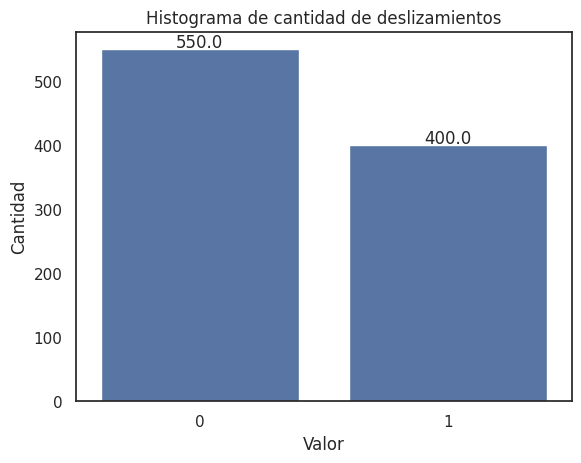

In [47]:
# Grafica el histograma usando Seaborn
ax=sns.countplot(data=df, x='deslizamientos')

# Añade etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Histograma de cantidad de deslizamientos')
# Agrega los valores en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

Donde 0 representa la clase negativa que es "Deslizamiento de tierra" en punto geográfico 
y 1 representa la clase positiva que es "No deslizamiento de tierra" 

Esta es la lógica que seguiremos en las implementaciones. 

Como podemos ver, no se presenta un problema grande de desbalance, ya que hay una relación de aproximadamente 40/60 de cada tipo de clase, por lo general se establece que hay desbalance de clases cuando hay una relación 10/90. Pero vemos que este no es el caso 

Ahora vemos cómo se comportan las variables de precipitación de lluvia respecto la variable objetivo 

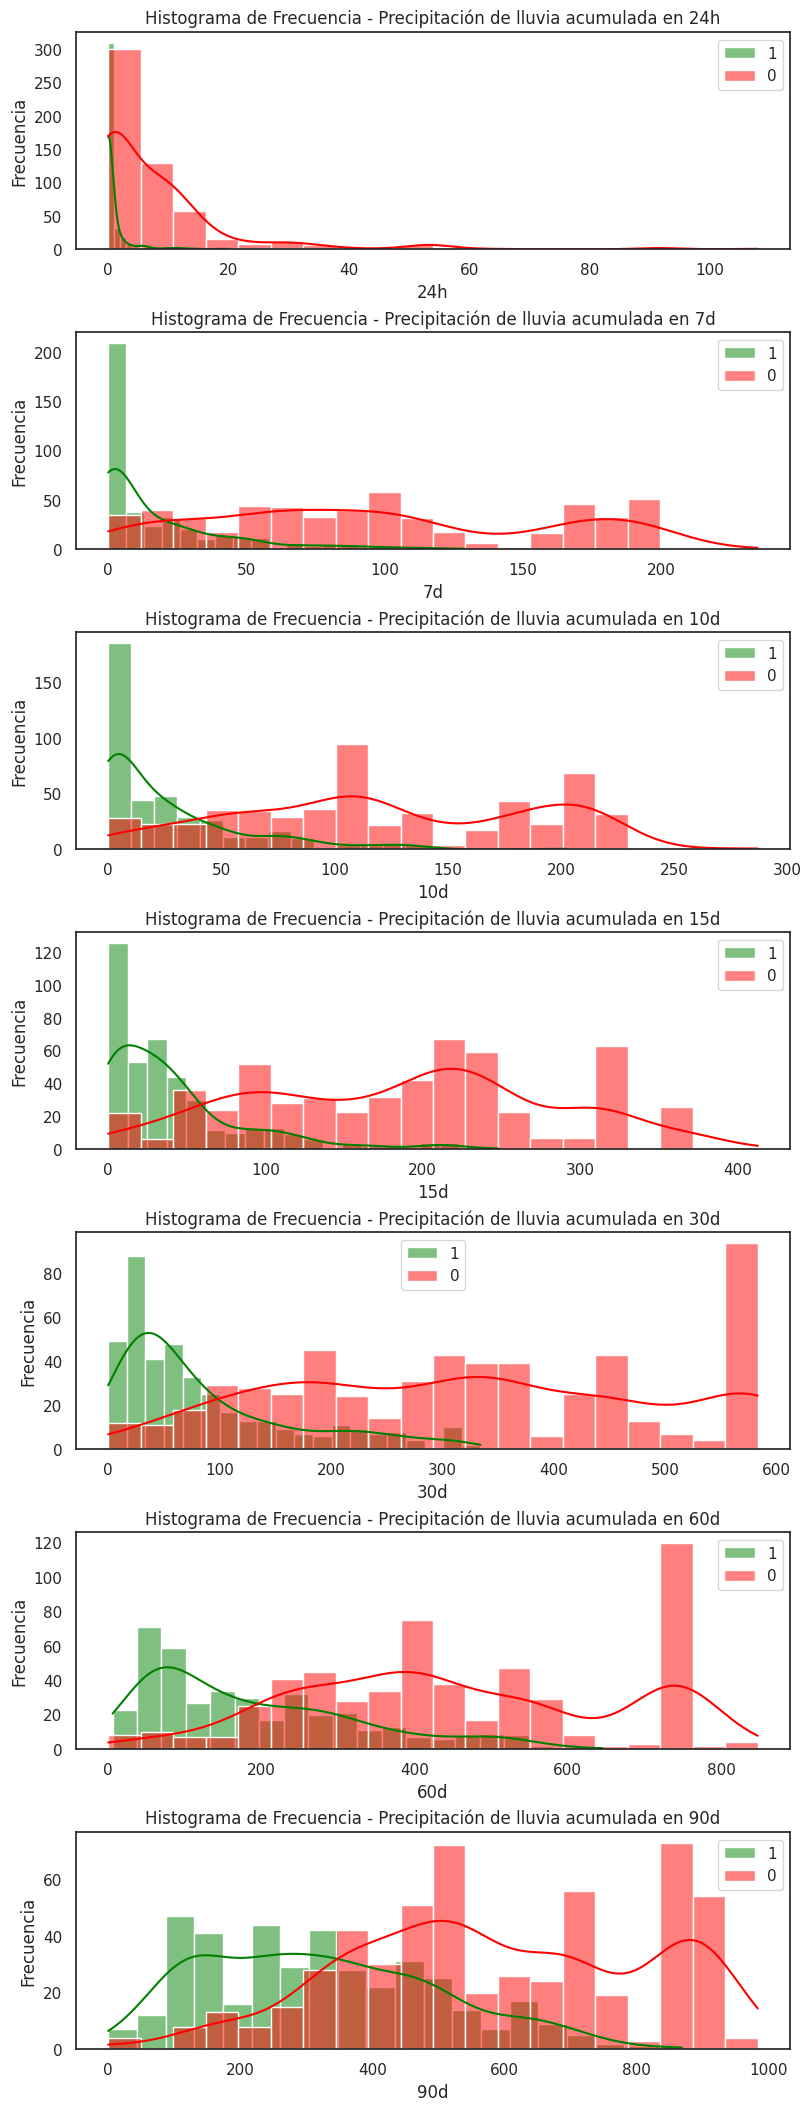

In [48]:
columnas_a_graficar = ['24h', '7d', '10d','15d','30d','60d','90d'] 
n = len(columnas_a_graficar)
fig, axes = plt.subplots(n, 1, figsize=(8, 3 * n), constrained_layout=True)
if n == 1:
    axes = [axes]
for columna, ax in zip(columnas_a_graficar, axes):
    graficar_histograma(df, y='deslizamientos', x=columna, ax=ax)
plt.show()

En este caso vemos que tenemos que para puntos donde ha habido deslizamientos de tierra, existe mayor cantidad de lluvia acumulada en mm en los últimos 15 días en comparación con los que no han presentado deslizamientos. Esto nos da un indicio de que las variables de precipitación son importantes para estimar si existe deslizamientos o no   

También podremos pensar que al tratarse de variables que capturan data de manera acumulada, puede haber valor que da una variable que también lo de otra, podemos revisar las correlaciones entre las precipitaciones 

## Variables categóricas

Ahora veamos las relaciones de las variables categoricas con el objetivo

In [49]:
resultados = {}
columnas_comparar=['zonificacion','Nomenclatura_del_Suelo','tipo_geologia']
for c in columnas_comparar:
    tabla = crear_tabla_contingencia(df, c, 'deslizamientos')
    resultados[c] = tabla

In [50]:
resultados['zonificacion']

,zonificacion,0,1
4,Riesgo alto,206,0
5,Riesgo bajo,169,206
6,Riesgo medio,104,0
2,Amenaza media,27,0
0,Amenaza alta,26,0
1,Amenaza baja,15,194
3,Amenaza muy alta,3,0


In [51]:
resultados['Nomenclatura_del_Suelo']

,Nomenclatura_del_Suelo,0,1
25,Zonas urbanas continuas,401,98
16,Otras superficies artificiales sin construcción,34,9
26,Zonas urbanas discontinuas,25,36
7,Bosque mixto denso alto de tierra firme,14,13
24,Vegetación secundaria o transición,11,14
5,Bosque mixto abierto alto de tierra firme,10,10
19,Pasto cultivado,10,38
20,Pasto cultivado arbolado,9,50
8,Bosque mixto denso bajo de tierra firme,9,25
14,Otras asociaciones de cultivos,5,0


In [52]:
resultados['tipo_geologia']

,tipo_geologia,0,1
9,Formacion Volcanica,345,84
10,Lateritas Formacion Volcanica,113,86
7,Formacion Guachinte,79,20
2,Cono aluvial rio Melendez,5,20
8,Formacion Jamundi,3,96
11,Stock de Pance – Gabro hornblendico,2,1
1,Cono aluvial 2 rio Pance,1,37
3,Conos aluviales,1,3
4,Depositos aluviales,1,7
0,Cono aluvial 1 rio Pance,0,28


Las variables categóricas con muy pocas frecuencias pueden presentar varios desafíos y consideraciones, por ejemplo: 
  

- Sobre-ajuste: Las categorías que aparecen solo unas pocas veces pueden llevar a modelos que se ajustan demasiado a esos casos específicos, capturando el ruido en lugar de patrones generales. Esto puede disminuir la capacidad de generalización del modelo a datos no vistos.  


- Estabilidad en el entrenamiento: Dado que el modelo tiene pocos ejemplos de estas categorías, puede ser difícil para el modelo aprender patrones representativos. Las categorías con baja frecuencia pueden no tener suficientes datos para permitir que el modelo aprenda características significativas, lo que puede llevar a una mala representación de esas categorías en el modelo. 


Todo esto puede afectar en las métricas de evaluación, como la precisión, el recall, y la F1-score, ya que el rendimiento en estas categorías raras puede no estar bien representado 

## Correlaciones entre variables independientes

Queremos que haya la menor correlación lineal y no lineal entre las variables independientes, ya que queremos que cada variable aporte su valor único al modelo, y evitar redundancias

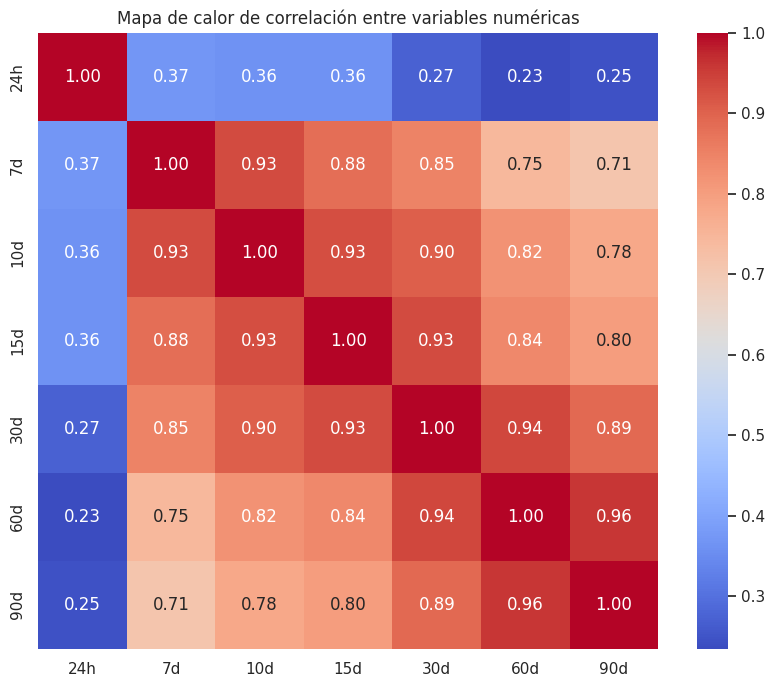

In [53]:
# Correlaciones entre variables independientes
correlation_matrix = df[columnas_a_graficar].corr(method='pearson')

# Configurar el estilo del mapa de calor

sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas')

# Mostrar el mapa de calor
plt.show()

Observamos que existe una alta correlación lineal entre las variables principalmente de precipitación, dándonos a entender que no son del todo independientes y que a medida que suben los dias (10 dias, 15 dias, 30 dias y así sucesivamente) aumenta su dependencia.

Esto genera multicolinealidad, lo que puede hacer que los coeficientes en modelos lineales (como la regresión logística, que se modelará en este analisis) se vuelvan inestables y difíciles de interpretar, esto ocurre porque el modelo no puede distinguir fácilmente el efecto individual de cada variable correlacionada. 

Así mismo, las variables altamente correlacionadas aportan información redundante. Esto puede hacer que el modelo sea más complejo de lo necesario, sin mejorar el rendimiento predictivo, lo cual puede llevar a un modelo sobreajustado que no generaliza bien a datos nuevos. En algunos casos, los algoritmos de clasificación uqe se usaran en este analisis, como los árboles de decisión o los modelos basados en conjuntos (e.g., Random Forest, XGBoost), no se ven tan afectados por la multicolinealidad, pero la presencia de variables altamente correlacionadas puede todavía llevar a un modelo más complejo de lo necesario.